In [17]:
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import tensorflow_hub as hub
import cv2 as cv
import tensorflow as tf

Getting pretrained models from tensorflow hub.
https://tfhub.dev/s?module-type=image-classification

https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4

Pretrained model is trained on 224*224 size pictures.

In [18]:
#Below snipped it present on tensor hub site itself
classifier=keras.Sequential([
                             hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224,224,3))
])

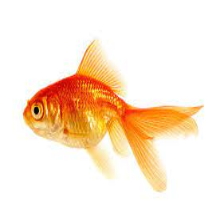

In [19]:
#Taking an image for classification
image=cv.imread("goldfish.jpg")
image=cv.resize(image,(224,224))
from google.colab.patches import cv2_imshow
cv2_imshow(image)

In [20]:
#Normalize the image
image=image/255

In [21]:
image.shape

(224, 224, 3)

In [22]:
#since multiple images can be passed to the model and input should be 4d. Converting it to 4D
image[np.newaxis, ...].shape

(1, 224, 224, 3)

In [23]:
#Classifying image
result=classifier.predict(image[np.newaxis, ...])

In [24]:
result

array([[ 0.26911572,  4.9892797 ,  6.749849  , ..., -1.6584696 ,
         1.3037786 , -1.2350117 ]], dtype=float32)

In [25]:
#Getting index of the image 
predicted_label_index= np.argmax(result)
predicted_label_index

2

In [26]:
#Getting list of classification for the model used in transfer learning
image_list=[]
import urllib
url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
file = urllib.request.urlopen(url)

for line in file:
	decoded_line = line.decode("utf-8")
	image_list.append(decoded_line.split("\n")[0])

#getting pur image name
image_list[predicted_label_index]

'goldfish'

In [27]:
#Getting flower dataset
dataset_url="https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
tf.keras.utils.get_file('flower_photos',origin=dataset_url,cache_dir='.',untar=True)

228827136/228813984 [==============================] - 2s 0us/step


'./datasets/flower_photos'

In [28]:
#Getting image values in the x and flower name in Y
data_direc="./datasets/flower_photos"
flowers= {0:'tulips',1:'roses',2:'dandelion',3:'sunflowers',4:'daisy'}
x=[]
y=[]
for i in range(0,5):
  images_in_folder=os.listdir(os.path.join(data_direc,flowers[i]))
  for image in images_in_folder:
    image_data=os.path.join(data_direc,flowers[i],image)
    x.append(cv2.resize(cv2.imread(image_data),(224, 224)))
    y.append(i)


In [29]:
#Normalize
x_scalled=np.array(x)/255
y=np.array(y)

In [30]:
#Perform Train test split
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test)=train_test_split(x,y,test_size=0.2)

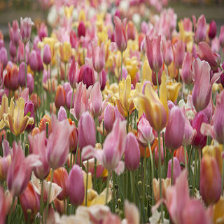

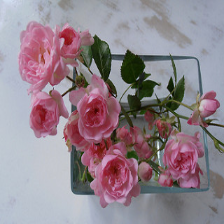

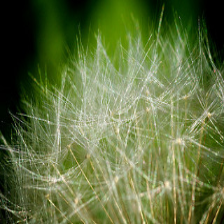

In [39]:
cv2_imshow(x[54])
cv2_imshow(x[1154])
cv2_imshow(x[2254])

In [40]:
predicted=classifier.predict(np.array([x[54],x[1154],x[2254]]))

In [41]:
#Getting label number using argmax and getting label name out of it
predicted_lable_number=np.argmax(predicted, axis=1)
predicted_lable_number


array([795, 795, 722])

In [43]:
image_list[predicted_lable_number[2]]

'pillow'

## Now starts concept of transfer learning

In [44]:
#Getting pretrained model, here trainable=False is important since it is freeze (means do not train and weights will be fixed)
feature_exctractor_model= "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
pretrained_model_without_top_layer= hub.KerasLayer(
        feature_exctractor_model, input_shape=(224,224,3),trainable=False                        
        )

In [56]:
#Using pretrained model and adding final layer
num_of_flower=5

model=tf.keras.Sequential([
        pretrained_model_without_top_layer,
        #tf.keras.layers.Dense(50,activation='relu'),
        tf.keras.layers.Dense(num_of_flower)
              ])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_10 (Dense)            (None, 5)                 5010      
                                                                 
Total params: 3,545,275
Trainable params: 5,010
Non-trainable params: 3,540,265
_________________________________________________________________


In [57]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.fit(np.array(x_train),np.array(y_train),epochs=10)

Epoch 1/10
92/92 [==============================] - 9s 81ms/step - loss: 1.4182 - acc: 0.4336
Epoch 2/10
92/92 [==============================] - 7s 79ms/step - loss: 1.1805 - acc: 0.5443
Epoch 3/10
92/92 [==============================] - 7s 79ms/step - loss: 1.1151 - acc: 0.5763
Epoch 4/10
92/92 [==============================] - 7s 80ms/step - loss: 1.0432 - acc: 0.6022
Epoch 5/10
92/92 [==============================] - 7s 80ms/step - loss: 1.0019 - acc: 0.6230
Epoch 6/10
92/92 [==============================] - 7s 80ms/step - loss: 0.9919 - acc: 0.6270
Epoch 7/10
92/92 [==============================] - 7s 80ms/step - loss: 0.9827 - acc: 0.6318
Epoch 8/10
92/92 [==============================] - 7s 80ms/step - loss: 0.9587 - acc: 0.6287
Epoch 9/10
92/92 [==============================] - 7s 80ms/step - loss: 0.9416 - acc: 0.6475
Epoch 10/10
92/92 [==============================] - 7s 80ms/step - loss: 0.9202 - acc: 0.6533


In [58]:
model.evaluate(np.array(x_test),np.array(y_test))

23/23 [==============================] - 3s 81ms/step - loss: 1.1141 - acc: 0.5926


[1.1141372919082642, 0.5926430225372314]